# Introduction: Visualization of real estate data

In this jupyter notebook we will take a closer look into our scraped real estate data through visualization of some of the most important attributes.

In [1]:
# Importting libraries
import json
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Loading db connection parameters from json file
db_params = None
with open('../database/db_connetion.json') as db_file:
    # Loading db connection parameters 
    db_params = json.load(db_file)

In [3]:
# Connecting to the database
conn = psycopg2.connect(
    host=db_params['host'], 
    port=db_params['port'], 
    database=db_params['database'], 
    user=db_params['user'], 
    password=db_params['password']
    )

In [4]:
# Getting the real estate data from database
real_estate = pd.read_sql_query('Select * from real_estate', conn)

In [5]:
def get_number_of_properties(dataframe, column_name, lower_bound=None, upper_bound=None):
    """
    From given dataframe returns number of rows for which the value of selected column name satisfies the bound conditions.
    
    dataframe: dataframe from which to extract information.
    column_name: name of the column in given dataframe on which we will apply conditions.
    lower_bound: value that signifies lower bound value for values under given column name.
    upper_bound: value that signifies upper bound value for values under given column name.
    returns: number of rows in given dataframe that satisfy given column conditions.
    """
    if lower_bound and upper_bound:        
        # value = (lower_bound, upper_bound)
        return dataframe[(dataframe[column_name].astype(float) >= lower_bound) & (dataframe[column_name].astype(float) < upper_bound)].shape[0]
    elif lower_bound:
        # value > lower_bound
        return dataframe[(dataframe[column_name].astype(float) >= lower_bound)].shape[0]
    elif upper_bound:
        # value < upper_bound
        return dataframe[(dataframe[column_name].astype(float) < upper_bound)].shape[0]
    else:
        return None

# 1. Number of houses and apartments for sale in Belgrade's districts

In [6]:
# Sorting out correct name for city district in Belgrade
indexes_to_replace = real_estate[real_estate['location_city_district'] == 'novi beo'].index
real_estate.iloc[indexes_to_replace,:]

for index in indexes_to_replace:
    real_estate.at[index, 'location_city_district'] = 'novi beograd'

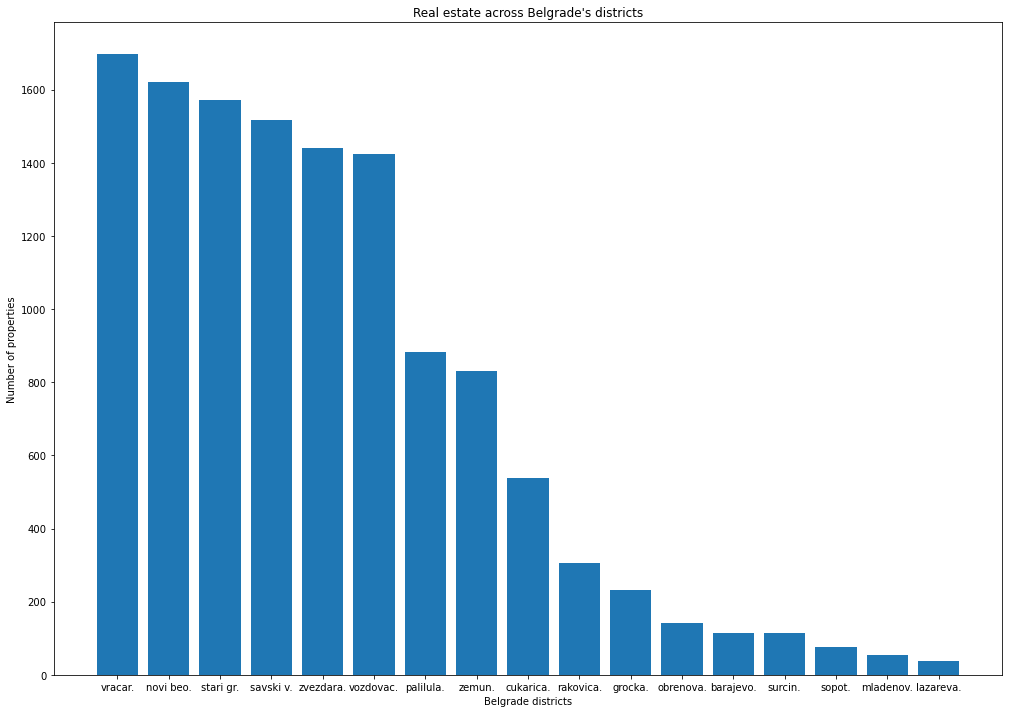

In [7]:
# Selecting only properties in Belgrade and grouping them by city district 
city_districts = real_estate[real_estate['location_city'] == 'beograd'].groupby(['location_city_district']).count().sort_values('id', ascending=False).head(50)

# Plotting Belgrade's districts and number of listed properties for sale in them
plt.figure(figsize=(17, 12)) 
plt.bar(list(map(lambda city_name:city_name[:8] + '.', city_districts.index)), city_districts['id'])
plt.title("Real estate across Belgrade's districts")
plt.xlabel('Belgrade districts')
plt.ylabel('Number of properties')
plt.show()

# 2. Flat size distribution

In [8]:
# Selecting only apartments for sale
apartments_for_sale = real_estate[(real_estate['listing_type'] == 's') & (real_estate['property_type'] == 'a')]

# Grouping apartments for sale based on their size
area_group_1 = get_number_of_properties(apartments_for_sale, 'area_property', None, 35)
area_group_2 = get_number_of_properties(apartments_for_sale, 'area_property', 35, 50)
area_group_3 = get_number_of_properties(apartments_for_sale, 'area_property', 50, 65)
area_group_4 = get_number_of_properties(apartments_for_sale, 'area_property', 65, 80)
area_group_5 = get_number_of_properties(apartments_for_sale, 'area_property', 80, 95)
area_group_6 = get_number_of_properties(apartments_for_sale, 'area_property', 95, 100)
area_group_7 = get_number_of_properties(apartments_for_sale, 'area_property', 110)

In [9]:
labels = [
    '<35',
    '35-50',
    '50-65',
    '65-80',
    '80-95',
    '95-110',
    '>100',
]

In [10]:
# Creating dataframe that contains information about apartment size and number of apartments in each size group
apartments_sizes = pd.DataFrame(
    data=[area_group_1, area_group_2, area_group_3, area_group_4, area_group_5, area_group_6, area_group_7],
    index=labels,
    columns=['NumberOfProperties']
)

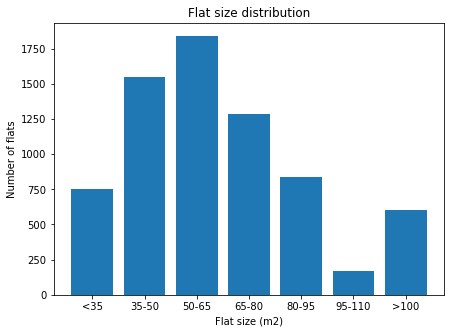

In [11]:
# Plotting distribution of flat size
plt.figure(figsize=(7, 5)) 
plt.bar(apartments_sizes.index, apartments_sizes['NumberOfProperties'])
plt.title("Flat size distribution")
plt.xlabel('Flat size (m2)')
plt.ylabel('Number of flats')
plt.show()

# 3. Year of construction distribution

In [12]:
# Selecting only real estate properties that have information on year they were built
real_estate_year = real_estate[real_estate['construction_type'].notnull()]

# Grouping houses and flats based on the year of construction
year_group_1 = get_number_of_properties(real_estate_year, 'construction_type', 1950, 1960)
year_group_2 = get_number_of_properties(real_estate_year, 'construction_type', 1960, 1970)
year_group_3 = get_number_of_properties(real_estate_year, 'construction_type', 1970, 1980)
year_group_4 = get_number_of_properties(real_estate_year, 'construction_type', 1980, 1990)
year_group_5 = get_number_of_properties(real_estate_year, 'construction_type', 1990, 2000)
year_group_6 = get_number_of_properties(real_estate_year, 'construction_type', 2000, 2010)
year_group_7 = get_number_of_properties(real_estate_year, 'construction_type', 2010, 2020)
year_group_8 = get_number_of_properties(real_estate_year, 'construction_type', 2020)

In [13]:
labels = [
    '1950-1960',
    '1960-1970',
    '1970-1980',
    '1980-1990',
    '1990-2000',
    '2000-2010',
    '2010-2020',
    '>2020'
]

In [14]:
# Creating dataframe that contains information about flat/house built years
year_groups = pd.DataFrame(
    data=[year_group_1, year_group_2, year_group_3, year_group_4, year_group_5, year_group_6, year_group_7, year_group_8],
    index=labels,
    columns=['NumberOfProperties']
)

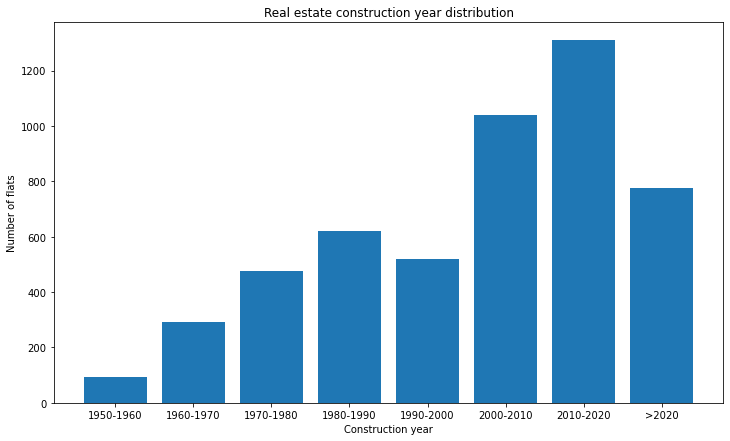

In [15]:
# Plotting construction year distribution
plt.figure(figsize=(12, 7)) 
plt.bar(year_groups.index, year_groups['NumberOfProperties'])
plt.title("Real estate construction year distribution")
plt.xlabel('Construction year')
plt.ylabel('Number of flats')
plt.show()

# 4. Number of sales/rental ads in top 5 cities by number of listings

In [17]:
# Getting the list of top 5 cities by number of real estate listings in them
top5_cities = real_estate.groupby(['location_city']).count().sort_values('id', ascending=False)['id'].head(5)
top5_cities

location_city
beograd       12677
novi sad       4398
nis            1334
kragujevac      796
subotica        250
Name: id, dtype: int64

In [18]:
def get_number_of_sale_and_rent_listings_in_city(real_estate, location_city):
    """
    Returns the number of sales and rental ads in given city.
    
    real_estate: dataframe containing real estate information.
    location_city: name of the city on which we will select desired information.
    returns: touple with two elements: number of sell ads and number of rental ads in given city.
    """
    sell = real_estate[(real_estate['location_city'] == location_city) & (real_estate['listing_type'] == 's')].shape[0]
    rent = real_estate[(real_estate['location_city'] == location_city) & (real_estate['listing_type'] == 'r')].shape[0]
    return (sell, rent)

In [19]:
# Getting information on sales and rental ads in top 5 cities
top5_cities_stats = []
for city in top5_cities.index:
    sell, rent = get_number_of_sale_and_rent_listings_in_city(real_estate, city)
    top5_cities_stats.append([city, sell, rent])

In [20]:
labels = ['Sell', 'Rent']
top5_cities_stats

[['beograd', 6433, 6244],
 ['novi sad', 3380, 1018],
 ['nis', 958, 376],
 ['kragujevac', 641, 155],
 ['subotica', 247, 3]]

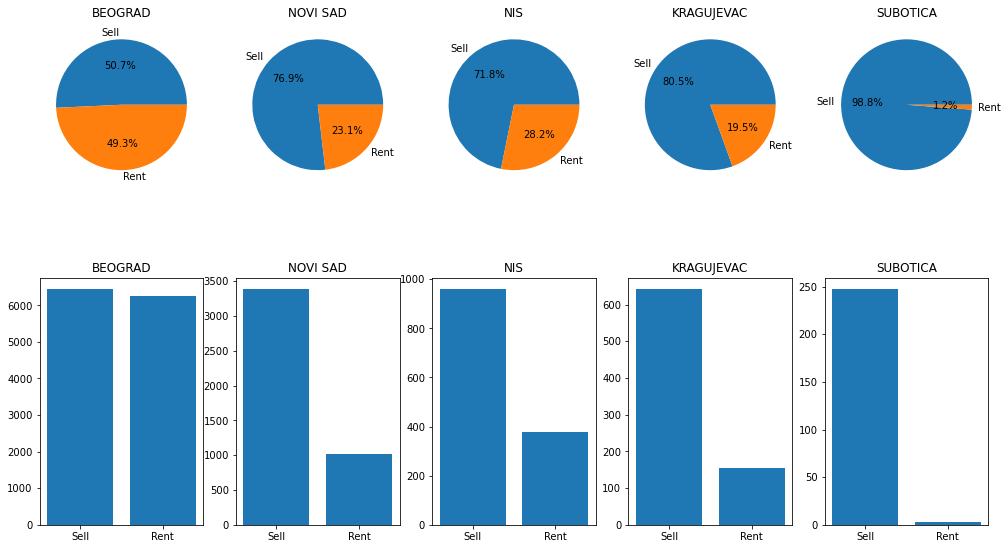

In [21]:
# Plotting sales/rental ads statistics for top 5 cities
# For each of the city we will have 2 plots: 
# 1. Pie plot for displaying the percetage
# 2. Bar plot for displaying the absolute sales and rental number in that city

# Creating 2x5 subplots 
fig, axs = plt.subplots(2, 5, figsize=[17, 10])

for i in range(0, 5):
    # Creating pie plot in the first row
    axs[0, i].set_title(top5_cities_stats[i][0].upper())
    axs[0, i].pie(top5_cities_stats[i][1:], labels = labels, autopct='%1.1f%%') 
    
    # Creating bar plot in the second row
    axs[1, i].set_title(top5_cities_stats[i][0].upper())
    axs[1, i].bar(labels, top5_cities_stats[i][1:]) 

# 5. Price segment distribution

In [22]:
# Getting only the properties that are listed for sale (both the flats and the houses) 
real_estate_for_sale = real_estate[real_estate['listing_type'] == 's']

# Grouping properties based on their price
price_group_1 = get_number_of_properties(real_estate_for_sale, 'price', None, 50000)
price_group_2 = get_number_of_properties(real_estate_for_sale, 'price', 50000, 100000)
price_group_3 = get_number_of_properties(real_estate_for_sale, 'price', 100000, 150000)
price_group_4 = get_number_of_properties(real_estate_for_sale, 'price', 150000, 200000)
price_group_5 = get_number_of_properties(real_estate_for_sale, 'price', 200000,)

In [23]:
labels = [
    '<50,000 €',
    '50,000-100,000€',
    '100,000-150,000€',
    '150,000-200,000€',
    '>200,000€',
]

In [24]:
# Creating a dataframe that contains information on propertys' prices
price_groups = pd.DataFrame(
    data=[price_group_1, price_group_2, price_group_3, price_group_4, price_group_5],
    index=labels,
    columns=['NumberOfProperties']
)

<BarContainer object of 5 artists>

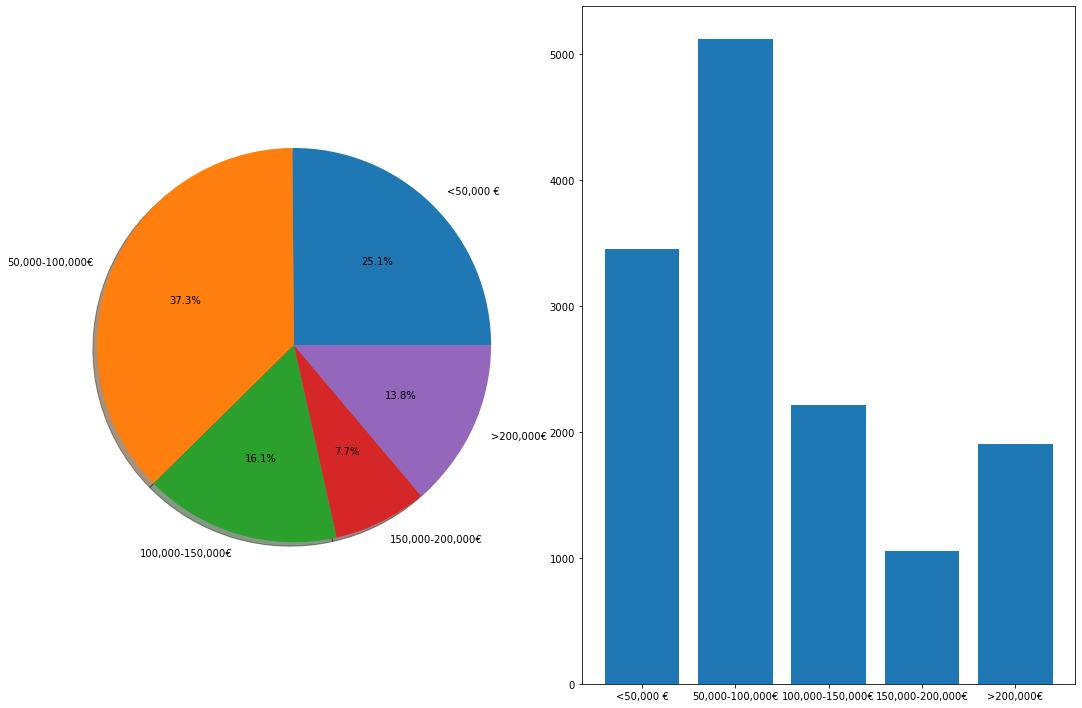

In [25]:
# Creating both the pie chart (displaying percetages) and the bar chart (displaying absolute values) for the price distribution

fig, axs = plt.subplots(1, 2, figsize=[15, 10])
fig.tight_layout()

axs[0].pie(price_groups['NumberOfProperties'], labels=labels, autopct='%1.1f%%', shadow=True)
axs[1].bar(price_groups.index, price_groups['NumberOfProperties'])